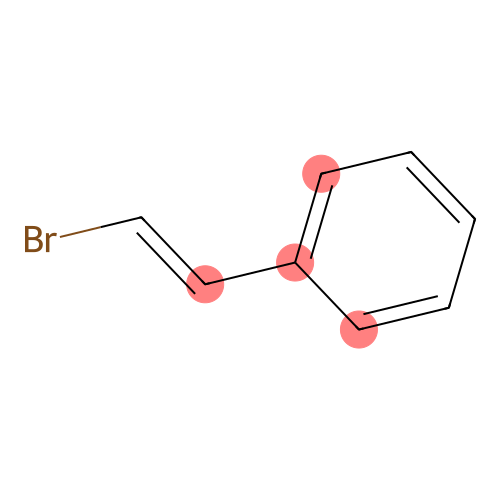

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdmolops import FindAtomEnvironmentOfRadiusN
import json
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

def visualize_substructure(smiles, env_json, bit=None):
    """
    Visualize substructure for a specific FCFP bit and return PIL Image.
    If bit is None, visualizes the first available environment.
    Returns None on failure.
    """
    # Parse SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Error: Invalid SMILES string: {smiles}")
        return None
    
    # Parse environment data
    try:
        env_data = json.loads(env_json)
    except json.JSONDecodeError:
        print("Error: Invalid JSON environment data")
        return None
    
    # If no bit specified, use the first one
    if bit is None and env_data:
        bit = next(iter(env_data.keys()))
        print(f"Using first available bit: {bit}")
    
    if not bit or bit not in env_data:
        print(f"Error: Bit '{bit}' not found in environment data")
        return None
    
    # Collect all atoms in the environment
    atom_ids = set()
    for center_atom, radius in env_data[bit]:
        # Get bonds in the environment
        env_bonds = FindAtomEnvironmentOfRadiusN(mol, radius, center_atom)
        
        # Get atoms from bonds
        for bond_idx in env_bonds:
            bond = mol.GetBondWithIdx(bond_idx)
            atom_ids.add(bond.GetBeginAtomIdx())
            atom_ids.add(bond.GetEndAtomIdx())
        
        # Always include center atom
        atom_ids.add(center_atom)
    
    # Create highlight colors
    highlight = {}
    for atom_id in atom_ids:
        highlight[atom_id] = (0, 0.8, 0)  # Green color
    
    # Draw molecule with highlights
    try:
        img = Draw.MolToImage(mol, 
                            highlightAtoms=list(atom_ids), 
                            highlightAtomColors=highlight,
                            highlightBonds=[],
                            size=(500, 500))
        return img
    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return None

# Example usage in notebook:
df = pd.read_csv('curated_SubOdor.csv')
row = df.iloc[0]
img = visualize_substructure(row['standardized_smiles'], row['fcfp_environments'], "594405804")

# To display in notebook:
display(img)
#
# To save to file:
# img.save('substructure.png')